# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_012  E9PKE3;P11142              14.948
Sample_177  P17677;P17677-2            21.605
Sample_052  A0A0D9SF30                 14.708
Sample_156  P00734                     21.105
Sample_059  Q9UMX0;Q9UMX0-2;Q9UMX0-4   14.723
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups          
Sample_040  P42262;P42262-2;P42262-3   13.973
Sample_139  O76070                     12.365
Sample_059  P68104;Q5VTE0              12.584
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.945
            A0A075B6Q5                 12.815
            A0A075B6R2                 11.424
            A0A075B6S5                 13.352
            A0A087WSY4                 13.165
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.184
            Q9UI40;Q9UI40-2            13.289
            Q9UIW2                     13.027
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.634
            Q9UP79                     12.046
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.493,15.050,16.842,19.863,13.738,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.474,19.067,...,15.528,15.576,12.715,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.731,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.784,17.705,17.039,11.417,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.395,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,10.750,15.345,17.084,18.708,14.249,19.433,8.322,9.841
Sample_207,15.739,16.877,15.469,16.898,15.088,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.460,14.036,13.488,12.148,15.006,13.123,12.119,13.380,13.779,12.401
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.515,19.067,16.127,...,11.475,11.278,12.336,12.668,12.777,12.595,12.426,12.900,13.054,12.334
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.456,13.628,11.652,11.405,12.717,12.626,12.906,12.313,13.743,13.158
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.511,13.364,12.559,12.200,12.691,12.231,13.363,12.986,13.850,12.328
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.667,11.744,12.378,13.432,13.293,12.166,12.768,12.402,11.942,13.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.320,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 323.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.49it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.61it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.86it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.52it/s]

100%|██████████| 5/5 [00:01<00:00,  4.31it/s]

100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.05it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.62it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.12it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.85it/s]

100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.12it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.81it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.83it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.64it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.49it/s]

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.86it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.89it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.90it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.91it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.45it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  2.94it/s]

100%|██████████| 8/8 [00:02<00:00,  2.72it/s]

100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.33it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.97it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.01it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.76it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.63it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.42it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.46it/s]

100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.02it/s]

 30%|███       | 3/10 [00:00<00:01,  4.11it/s]

 40%|████      | 4/10 [00:01<00:01,  3.47it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.88it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.61it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.53it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.49it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.52it/s]

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.51it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.27it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.83it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.75it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.60it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.52it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.55it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.67it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:03<00:00,  2.70it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.15it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.81it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.47it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.39it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.42it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.50it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.71it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.14it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.18it/s]

100%|██████████| 12/12 [00:04<00:00,  3.12it/s]

100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.58it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.52it/s]

 31%|███       | 4/13 [00:01<00:02,  3.18it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.91it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.84it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.84it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.12it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.04it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.95it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.96it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.97it/s]

100%|██████████| 13/13 [00:04<00:00,  2.94it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.77it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.33it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.04it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.76it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.81it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.81it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  3.00it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.99it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.95it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.96it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.93it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.85it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.89it/s]

 20%|██        | 3/15 [00:00<00:02,  4.52it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.57it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.20it/s]

 40%|████      | 6/15 [00:01<00:03,  2.68it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.47it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.87it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.88it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.06it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.10it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.23it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.32it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.10it/s]

100%|██████████| 15/15 [00:04<00:00,  3.24it/s]

100%|██████████| 15/15 [00:04<00:00,  3.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.056 0.030          0.876 0.208       0.163   
2             0.004 0.002      0.047 0.023          0.784 0.079       0.728   
3             0.006 0.005      0.065 0.031          0.789 0.097       0.741   
4             0.003 0.000      0.035 0.003          0.815 0.090       0.801   
5             0.005 0.004      0.050 0.025          0.816 0.086       0.803   
6             0.006 0.006      0.065 0.031          0.840 0.079       0.849   
7             0.006 0.005      0.067 0.029          0.841 0.081       0.853   
8             0.006 0.006      0.058 0.026          0.836 0.081       0.838   
9             0.004 0.004      0.045 0.018          0.832 0.081       0.847   
10            0.005 0.005      0.046 0.023          0.829 0.083       0.839   
11            0.004 0.002      0.037 0.005          0.833 0.082       0.840   
12            0.004 0.002      0.036 0.012          0.832 0.080       0.826   
13            0.004 0.003      0.039 0.009          0.829 0.076       0.822   
14            0.004 0.002      0.040 0.010          0.829 0.080       0.822   
15            0.005 0.003      0.045 0.016          0.826 0.084       0.820   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.266 0.125                  0.573 0.043        0.861   
2          0.102   0.750 0.072                  0.789 0.057        0.866   
3          0.113   0.758 0.080                  0.795 0.064        0.891   
4          0.113   0.802 0.075                  0.832 0.062        0.893   
5          0.106   0.804 0.070                  0.833 0.059        0.896   
6          0.090   0.841 0.063                  0.864 0.053        0.920   
7          0.092   0.843 0.064                  0.866 0.055        0.919   
8          0.095   0.833 0.065                  0.857 0.056        0.918   
9          0.088   0.836 0.063                  0.859 0.055        0.918   
10         0.094   0.831 0.068                  0.855 0.059        0.917   
11         0.093   0.833 0.066                  0.857 0.057        0.916   
12         0.092   0.825 0.063                  0.850 0.053        0.914   
13         0.093   0.822 0.063                  0.848 0.054        0.913   
14         0.091   0.821 0.064                  0.847 0.055        0.912   
15         0.090   0.819 0.064                  0.845 0.054        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.828 0.086        210.000 0.000  
2          0.058                  0.825 0.074        210.000 0.000  
3          0.055                  0.860 0.079        210.000 0.000  
4          0.054                  0.868 0.068        210.000 0.000  
5          0.051                  0.870 0.063        210.000 0.000  
6          0.047                  0.908 0.051        210.000 0.000  
7          0.049                  0.908 0.052        210.000 0.000  
8          0.049                  0.909 0.050        210.000 0.000  
9          0.050                  0.909 0.052        210.000 0.000  
10         0.051                  0.908 0.052        210.000 0.000  
11         0.051                  0.907 0.053        210.000 0.000  
12         0.052                  0.905 0.052        210.000 0.000  
13         0.051                  0.904 0.052        210.000 0.000  
14         0.052                  0.903 0.053        210.000 0.000  
15         0.051                  0.907 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 450.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.65it/s]

100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.14it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.72it/s]

100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.09it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.63it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.35it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.39it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.33it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.29it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.15it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.13it/s]

100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.49it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.43it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.82it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.56it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.60it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.66it/s]

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.73it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.43it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.05it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.84it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.73it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.60it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.42it/s]

100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.56it/s]

 30%|███       | 3/10 [00:00<00:01,  3.85it/s]

 40%|████      | 4/10 [00:01<00:01,  3.21it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.03it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.19it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.36it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.17it/s]

100%|██████████| 10/10 [00:02<00:00,  3.25it/s]

100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.33it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.87it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.93it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.75it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.44it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.51it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.56it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.01it/s]

 91%|█████████ | 10/11 [00:02<00:00,  2.81it/s]

100%|██████████| 11/11 [00:03<00:00,  2.70it/s]

100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.08it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.98it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.87it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.79it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.81it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.05it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.02it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.13it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.32it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.42it/s]

100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

100%|██████████| 12/12 [00:03<00:00,  3.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.57it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.75it/s]

 31%|███       | 4/13 [00:01<00:02,  3.54it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.29it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.21it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.17it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.23it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.92it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.67it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.45it/s]

100%|██████████| 13/13 [00:04<00:00,  2.55it/s]

100%|██████████| 13/13 [00:04<00:00,  2.96it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  4.00it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.99it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.45it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.18it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.01it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.92it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.94it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.08it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.09it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.21it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.25it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.37it/s]

100%|██████████| 14/14 [00:06<00:00,  2.32it/s]

100%|██████████| 14/14 [00:06<00:00,  2.25it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.53it/s]

 20%|██        | 3/15 [00:00<00:03,  3.27it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.91it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.97it/s]

 40%|████      | 6/15 [00:01<00:02,  3.11it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.13it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.28it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.36it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.57it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.63it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.70it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.76it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.80it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

100%|██████████| 15/15 [00:04<00:00,  3.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.065 0.025          0.832 0.274       0.134   
2             0.005 0.005      0.054 0.019          0.706 0.109       0.583   
3             0.005 0.004      0.048 0.020          0.769 0.103       0.693   
4             0.005 0.004      0.054 0.025          0.768 0.101       0.700   
5             0.004 0.000      0.042 0.013          0.808 0.083       0.757   
6             0.004 0.003      0.039 0.017          0.838 0.083       0.785   
7             0.004 0.003      0.034 0.008          0.832 0.085       0.776   
8             0.003 0.000      0.033 0.003          0.833 0.086       0.775   
9             0.005 0.005      0.048 0.019          0.832 0.092       0.776   
10            0.004 0.003      0.045 0.014          0.812 0.084       0.838   
11            0.005 0.004      0.047 0.018          0.818 0.082       0.820   
12            0.005 0.003      0.055 0.024          0.832 0.081       0.825   
13            0.005 0.004      0.044 0.016          0.833 0.084       0.824   
14            0.005 0.003      0.062 0.027          0.848 0.078       0.830   
15            0.006 0.005      0.047 0.019          0.835 0.089       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.222 0.122                  0.559 0.041        0.849   
2          0.120   0.630 0.097                  0.700 0.067        0.761   
3          0.121   0.723 0.093                  0.768 0.076        0.864   
4          0.135   0.726 0.100                  0.771 0.078        0.874   
5          0.111   0.776 0.075                  0.811 0.061        0.902   
6          0.093   0.806 0.068                  0.835 0.056        0.909   
7          0.100   0.799 0.072                  0.829 0.059        0.907   
8          0.099   0.798 0.071                  0.829 0.059        0.905   
9          0.112   0.797 0.077                  0.828 0.064        0.902   
10         0.099   0.821 0.073                  0.847 0.064        0.912   
11         0.091   0.815 0.065                  0.842 0.055        0.916   
12         0.090   0.824 0.062                  0.850 0.052        0.917   
13         0.089   0.825 0.065                  0.850 0.054        0.916   
14         0.085   0.835 0.057                  0.859 0.048        0.919   
15         0.094   0.817 0.064                  0.844 0.053        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.074                  0.732 0.096        210.000 0.000  
3          0.056                  0.828 0.076        210.000 0.000  
4          0.055                  0.829 0.076        210.000 0.000  
5          0.047                  0.881 0.054        210.000 0.000  
6          0.047                  0.893 0.056        210.000 0.000  
7          0.048                  0.889 0.058        210.000 0.000  
8          0.050                  0.888 0.060        210.000 0.000  
9          0.054                  0.885 0.063        210.000 0.000  
10         0.048                  0.899 0.053        210.000 0.000  
11         0.046                  0.904 0.053        210.000 0.000  
12         0.048                  0.904 0.057        210.000 0.000  
13         0.048                  0.904 0.056        210.000 0.000  
14         0.045                  0.908 0.051        210.000 0.000  
15         0.046                  0.907 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1188.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.00it/s]

100%|██████████| 3/3 [00:00<00:00, 16.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.28it/s]

100%|██████████| 4/4 [00:00<00:00, 17.22it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.02it/s]

100%|██████████| 5/5 [00:00<00:00, 20.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.08it/s]

100%|██████████| 6/6 [00:00<00:00, 17.31it/s]

100%|██████████| 6/6 [00:00<00:00, 17.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.68it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.80it/s]

100%|██████████| 7/7 [00:00<00:00, 16.52it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.92it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.54it/s]

100%|██████████| 8/8 [00:00<00:00, 14.53it/s]

100%|██████████| 8/8 [00:00<00:00, 15.40it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.38it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.61it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 15.15it/s]

100%|██████████| 9/9 [00:00<00:00, 15.51it/s]

100%|██████████| 9/9 [00:00<00:00, 15.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.20it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.87it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.80it/s]

100%|██████████| 10/10 [00:00<00:00, 15.14it/s]

100%|██████████| 10/10 [00:00<00:00, 15.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.15it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.25it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.90it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.07it/s]

100%|██████████| 11/11 [00:00<00:00, 14.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.80it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.22it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.02it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.49it/s]

100%|██████████| 12/12 [00:00<00:00, 13.55it/s]

100%|██████████| 12/12 [00:00<00:00, 14.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 28.18it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.31it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.27it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.25it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.89it/s]

100%|██████████| 13/13 [00:01<00:00, 12.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.98it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.17it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.42it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.58it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.19it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.61it/s]

100%|██████████| 14/14 [00:01<00:00, 13.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.19it/s]

 40%|████      | 6/15 [00:00<00:00, 17.45it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 17.52it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 17.24it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.38it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.94it/s]

100%|██████████| 15/15 [00:00<00:00, 16.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.031 0.013          0.524 0.447       0.051   
2             0.003 0.002      0.034 0.014          0.650 0.181       0.255   
3             0.003 0.000      0.033 0.004          0.595 0.115       0.393   
4             0.004 0.004      0.042 0.017          0.595 0.117       0.388   
5             0.004 0.002      0.037 0.012          0.579 0.101       0.395   
6             0.004 0.003      0.047 0.020          0.554 0.098       0.386   
7             0.005 0.004      0.053 0.021          0.542 0.104       0.380   
8             0.007 0.006      0.058 0.023          0.570 0.099       0.424   
9             0.005 0.006      0.057 0.027          0.552 0.098       0.412   
10            0.006 0.005      0.069 0.029          0.548 0.090       0.417   
11            0.006 0.005      0.053 0.022          0.568 0.113       0.496   
12            0.007 0.005      0.059 0.018          0.573 0.113       0.502   
13            0.005 0.003      0.047 0.018          0.578 0.099       0.502   
14            0.006 0.005      0.057 0.024          0.606 0.089       0.561   
15            0.007 0.005      0.068 0.021          0.611 0.097       0.543   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.052   0.090 0.087                  0.518 0.025        0.722   
2          0.080   0.356 0.091                  0.570 0.051        0.643   
3          0.092   0.467 0.087                  0.595 0.059        0.654   
4          0.092   0.464 0.089                  0.595 0.060        0.644   
5          0.088   0.464 0.079                  0.590 0.056        0.634   
6          0.086   0.449 0.076                  0.577 0.052        0.634   
7          0.101   0.441 0.091                  0.572 0.057        0.624   
8          0.090   0.481 0.082                  0.593 0.058        0.643   
9          0.092   0.466 0.080                  0.581 0.059        0.634   
10         0.090   0.467 0.074                  0.579 0.053        0.626   
11         0.113   0.524 0.100                  0.608 0.077        0.683   
12         0.102   0.530 0.094                  0.611 0.076        0.678   
13         0.097   0.532 0.084                  0.614 0.068        0.672   
14         0.133   0.576 0.095                  0.647 0.071        0.725   
15         0.123   0.569 0.099                  0.645 0.073        0.728   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.674 0.078        210.000 0.000  
2          0.091                  0.605 0.094        210.000 0.000  
3          0.089                  0.606 0.084        210.000 0.000  
4          0.087                  0.596 0.079        210.000 0.000  
5          0.087                  0.587 0.083        210.000 0.000  
6          0.080                  0.566 0.078        210.000 0.000  
7          0.082                  0.558 0.079        210.000 0.000  
8          0.086                  0.586 0.092        210.000 0.000  
9          0.086                  0.573 0.091        210.000 0.000  
10         0.086                  0.564 0.088        210.000 0.000  
11         0.083                  0.610 0.086        210.000 0.000  
12         0.083                  0.603 0.084        210.000 0.000  
13         0.086                  0.593 0.085        210.000 0.000  
14         0.077                  0.669 0.088        210.000 0.000  
15         0.079                  0.669 0.089 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,1,12
score_time,7,1,10
test_precision,1,14,2
test_recall,7,10,14
test_f1,7,14,14
test_balanced_accuracy,7,14,14
test_roc_auc,6,14,15
test_average_precision,9,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.17it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.12it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.61it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.27it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.19it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.08it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.20it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.23it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.37it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.55it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.71it/s]

100%|██████████| 14/14 [00:05<00:00,  2.97it/s]

100%|██████████| 14/14 [00:05<00:00,  2.56it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.91it/s]

 40%|████      | 6/15 [00:00<00:00, 17.73it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.87it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.55it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.15it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.31it/s]

100%|██████████| 15/15 [00:00<00:00, 15.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.66it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.21it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.50it/s]

100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


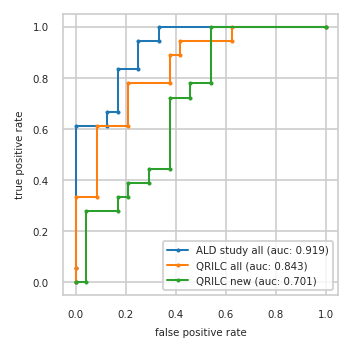

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.611     0.000 0.333     0.042 0.278
3          0.125 0.611     0.083 0.333     0.167 0.278
4          0.125 0.667     0.083 0.611     0.167 0.333
5          0.167 0.667     0.208 0.611     0.208 0.333
6          0.167 0.833     0.208 0.778     0.208 0.389
7          0.250 0.833     0.375 0.778     0.292 0.389
8          0.250 0.944     0.375 0.889     0.292 0.444
9          0.333 0.944     0.417 0.889     0.375 0.444
10         0.333 1.000     0.417 0.944     0.375 0.722
11         1.000 1.000     0.625 0.944     0.458 0.722
12           NaN   NaN     0.625 1.000     0.458 0.778
13           NaN   NaN     1.000 1.000     0.542 0.778
14           NaN   NaN       NaN   NaN     0.542 1.000
15           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,Q9NZ53,P60709;P63261,A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9B...
2,Q8IWT1,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,E7EPS8;P28827;P28827-2
3,P04075,P10636-2;P10636-6,D6R956;P09936
4,P14174,A0A0A0MRJ7;P12259,Q14894
5,P08253,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,None,P14174,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
7,None,P04075,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
8,None,P00338;P00338-3,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


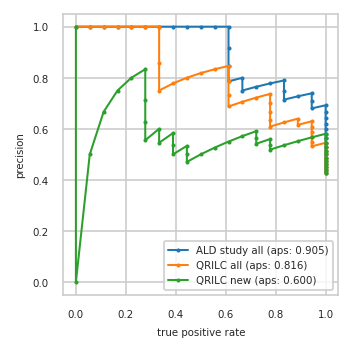

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.531 0.944     0.562 1.000
11         0.581 1.000     0.548 0.944     0.581 1.000
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.630 0.944     0.519 0.778
16         0.692 1.000     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.708 0.944     0.625 0.833     0.542 0.722
19         0.739 0.944     0.609 0.778     0.565 0.722
20         0.727 0.889     0.636 0.778     0.591 0.722
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.737 0.778     0.526 0.556
24         0.778 0.778     0.722 0.722     0.500 0.500
25         0.765 0.722     0.706 0.667     0.471 0.444
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.800 0.667     0.733 0.611     0.533 0.444
28         0.786 0.611     0.786 0.611     0.500 0.389
29         0.846 0.611     0.846 0.611     0.538 0.389
30         0.917 0.611     0.833 0.556     0.583 0.389
31         1.000 0.611     0.818 0.500     0.545 0.333
32         1.000 0.556     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


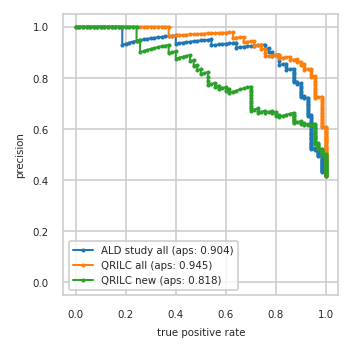

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


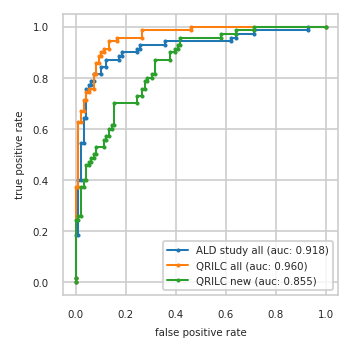

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}